Let us start importing the training data and test data

In [63]:
import pandas as pd
data_raw=pd.read_csv("train.csv")
test_raw=pd.read_csv("test.csv")

Assumptions for a first run: 
(1) Name of the passenger and ticket number are irrelevant.
(2) Cabin number could be very relevant but only ~1/5 of the data has this information. 
Let us implement this and clean up the data a little bit:

In [64]:
data_cleaned=data_raw.drop(["Name","Ticket","Cabin","PassengerId"],axis="columns")
test_cleaned=test_raw.drop(["Name","Ticket","Cabin","PassengerId"],axis="columns")

data_cleaned=data_cleaned.dropna(axis=0)

labels=data_cleaned["Survived"]
data_cleaned=data_cleaned.drop(["Survived"],axis="columns")

Next we need to One Hot Encode some categorical variables: Sex, Embarked (for both the data and test set)

In [65]:
from sklearn.preprocessing import OneHotEncoder
cols=["Sex","Embarked"]
ohe=OneHotEncoder()
ohe.fit(data_cleaned[cols])
data_cleaned[ohe.get_feature_names_out()]=ohe.transform(data_cleaned[cols]).toarray()
data_cleaned.drop(cols,axis="columns",inplace=True)

test_cleaned[ohe.get_feature_names_out()]=ohe.transform(test_cleaned[cols]).toarray()
test_cleaned.drop(cols,axis="columns",inplace=True)

Finally we have to standardize the data to mean=0 and std=1

In [66]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(data_cleaned)
X=scaler.transform(data_cleaned)

scaler=StandardScaler().fit(test_cleaned)
X_test=scaler.transform(test_cleaned)

The data is at this point ready to be used for learning. Let us start with a GridSearch of Logistic Regression. 

(1) The survival fraction is roughly 40% 

(2) We do not have incentives to either optimize the precision or the recall.

We can therefore use accuracy as a valid score.

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid={'C':[0.001,0.01,0.1,1,10,100,1000],'solver':['newton-cg','lbfgs','liblinear','sag','saga']}

log_reg=LogisticRegression()

grid_search=GridSearchCV(log_reg,param_grid,cv=5,scoring='accuracy',return_train_score=True)

grid_search.fit(X,labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)


{'C': 10, 'solver': 'newton-cg'}
LogisticRegression(C=10, solver='newton-cg')


The gridsearch yields 'C:10' and solver: 'newton-cg'. Let us now check if this is a reasonable model without overfitting or any other abberations.
We start by crossvalidating the scores on the training set.

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
log_reg=LogisticRegression(C=10 ,solver='newton-cg')
log_reg.fit(X,labels)
scores=cross_val_score(log_reg,X,labels,cv=5,scoring="accuracy")


def display_scores(scores):
    print("Scores: ", scores)
    print("Mean:", scores.mean())
    print("Standard deviation", scores.std())

display_scores(scores)


y_train_pred=cross_val_predict(log_reg,X,labels,cv=5)

Scores:  [0.72727273 0.83216783 0.76760563 0.77464789 0.81690141]
Mean: 0.7837190978036048
Standard deviation 0.03735363149455805


78% with a reasonably small standard deviation, that's not too bad. Let us also look at the learning curve to make sure there are no large gaps indicative of overfitting.

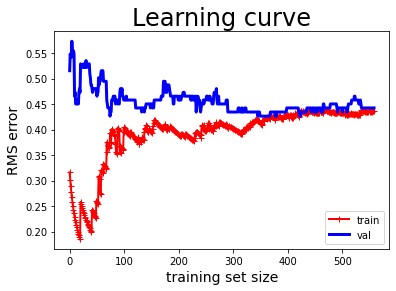

In [69]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(10, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")   
    plt.title("Learning curve", fontsize=24)
    plt.xlabel("training set size", fontsize=14)
    plt.ylabel("RMS error", fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

log_reg=LogisticRegression(C=10 ,solver='newton-cg')
plot_learning_curves(log_reg,X,labels)

The learning curve does not seem to be indicative of overfitting as the gap between the two sets quickly closes. Let us also look at the ROC:

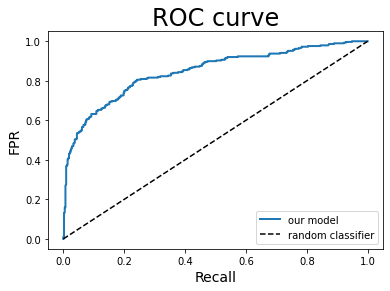

In [70]:
log_reg=LogisticRegression(C=10 ,solver='newton-cg')
log_reg.fit(X,labels)
y_train_proba=cross_val_predict(log_reg,X,labels,cv=5 ,method='predict_proba')
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(labels, y_train_proba[:,1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label='our model')
    plt.plot([0, 1], [0, 1], 'k--',label='random classifier') # dashed diagonal
    plt.title("ROC curve", fontsize=24)
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("FPR", fontsize=14)
    plt.legend(loc="lower right")

plot_roc_curve(fpr, tpr)
plt.show()

The ROC is not particularly impressive but shows no abberations. The model could arguably be improved further, but it seems to be a reasonable first result.

Let us see if we can do any better and look at the data more closely.


In [71]:
data_full=data_cleaned.join(labels)
corr_matrix=data_full.corr()
corr_matrix["Survived"].sort_values(ascending=False)


Survived      1.000000
Sex_female    0.536762
Fare          0.266100
Embarked_C    0.195673
Parch         0.095265
SibSp        -0.015523
Embarked_Q   -0.048966
Age          -0.082446
Embarked_S   -0.159015
Pclass       -0.356462
Sex_male     -0.536762
Name: Survived, dtype: float64

It seems that the survival rate is very strongly correlated with the sex. Let us try and remove the two lowest correlations.

In [86]:
data_cleaned2=data_cleaned.drop(["SibSp","Embarked_Q"],axis="columns")
log_reg=LogisticRegression(C=10 ,solver='newton-cg')
log_reg.fit(data_cleaned2,labels)
scores=cross_val_score(log_reg,data_cleaned2,labels,cv=5,scoring="accuracy")
display_scores(scores)


Scores:  [0.72727273 0.83216783 0.76760563 0.76056338 0.78873239]
Mean: 0.7752683935782527
Standard deviation 0.03463340790787578


This doesn't seem to improve the result. Of course, if we only remove something and don't add any more features this will not result in a better model. Let us therefore try and include polynomial dependence. 

In [73]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(data_cleaned2)
log_reg_poly = LogisticRegression(C=0.1,max_iter=3000,solver='newton-cg')
log_reg_poly.fit(X_poly, labels)
display_scores(scores)

Scores:  [0.72727273 0.83216783 0.76760563 0.76056338 0.78873239]
Mean: 0.7752683935782527
Standard deviation 0.03463340790787578


This does not seem to improve the accuracy by that much. Let us therefore choose our previous linear model as a final choice.

Let us now make the predictions on the final test set for submission. However the test set still contains some NaN, so let us replace them by their average values below.


In [91]:

age_mean=data_cleaned["Age"].mean()
fare_mean=data_cleaned["Fare"].mean()
test_cleaned['Age'].fillna(age_mean,inplace=True)
test_cleaned['Fare'].fillna(fare_mean,inplace=True)
 

scaler=StandardScaler().fit(test_cleaned)
X_test=scaler.transform(test_cleaned)


log_reg=LogisticRegression(C=10 ,solver='newton-cg')
log_reg.fit(X,labels)
test_pred=log_reg.predict(X_test)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


Finally let us write to the CSV file as instructed by the challenge

In [94]:
test_raw["PassengerId"][0]

892

In [102]:
import csv

filename='submission.csv'
 


with open(filename,'w') as file:
    file.write("PassengerId,Survived")
    file.write('\n')
    for i in range(len(test_pred)):
        file.write(str(test_raw["PassengerId"][i])+","+str(test_pred[i]))
        file.write('\n')